Starting map matching process...
Loading road network...
Loading trajectory data...
Building spatial index...
Performing map matching...


100%|██████████| 50/50 [00:00<00:00, 612.29it/s]


Analysis of map matching results:
Total trajectories matched: 50
Average edges per trajectory: 27.56
Visualizing results...


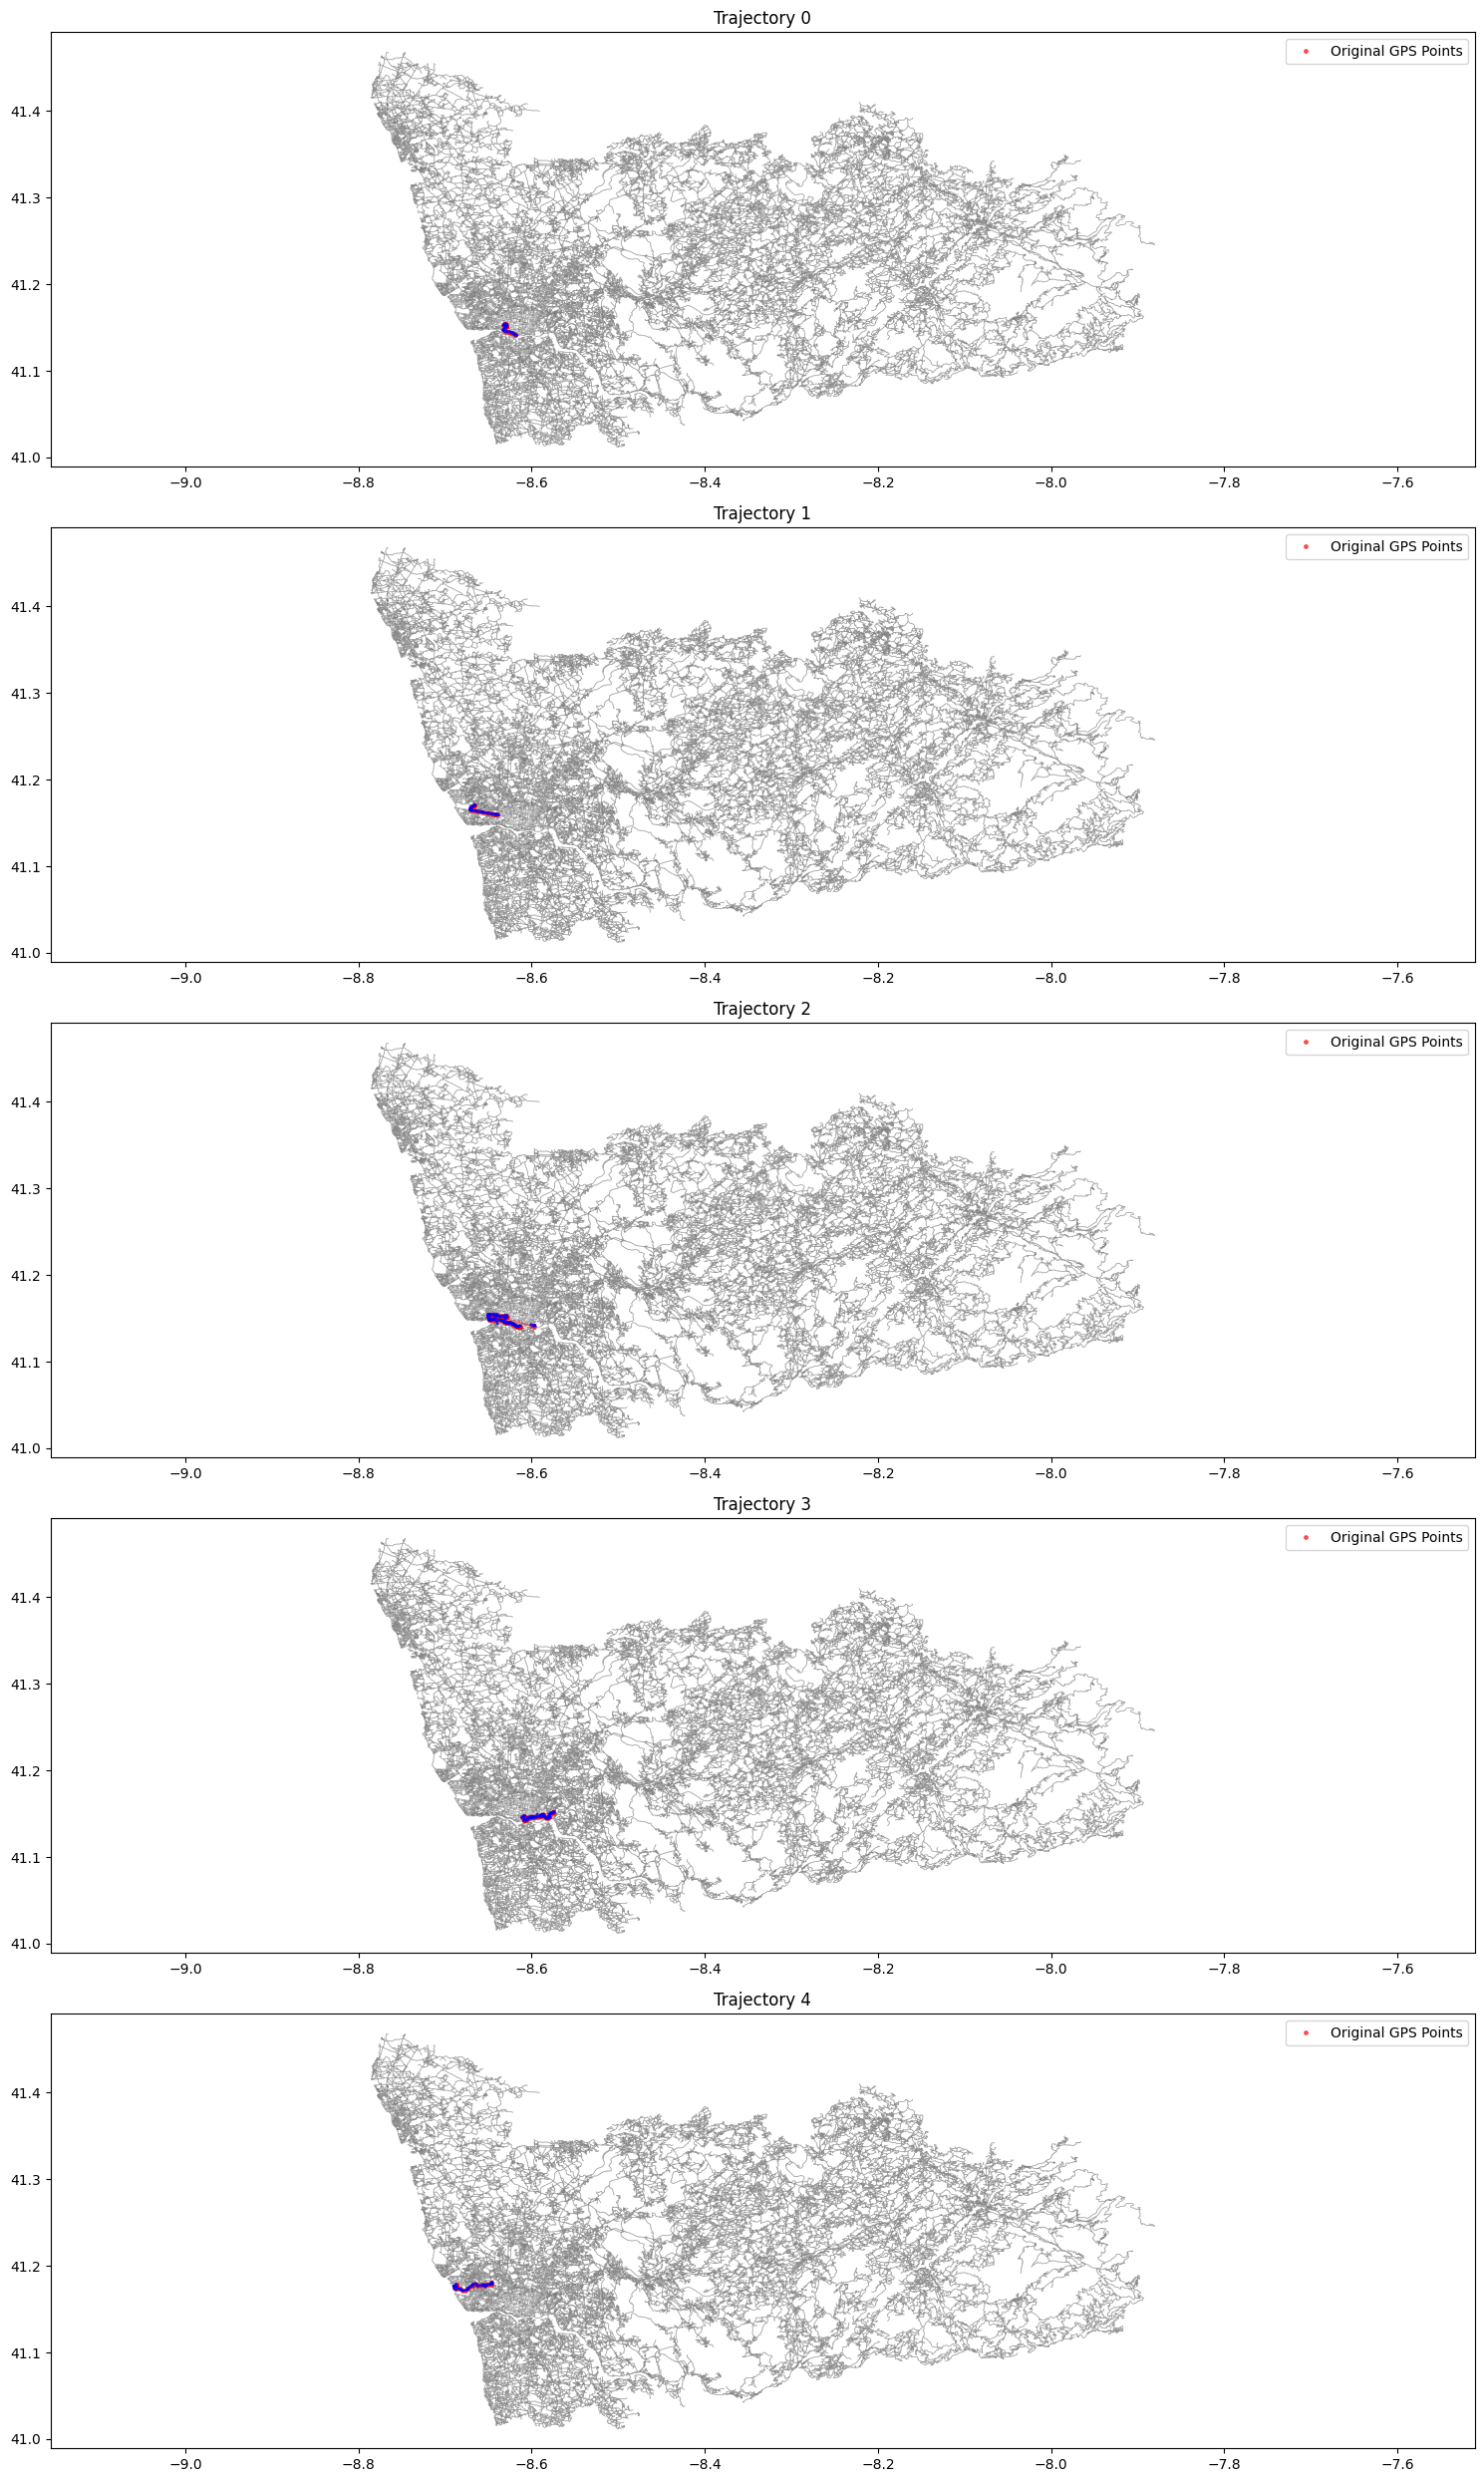


Results have been saved to 'map_matching_analysis.csv'


In [15]:
import osmnx as ox
import pandas as pd
import ast
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyproj import CRS
import networkx as nx
from datetime import datetime
from scipy.spatial import cKDTree
from shapely.ops import nearest_points
import warnings
warnings.filterwarnings('ignore')

class SimpleMapMatcher:
    def __init__(self, graph, edges_gdf):
        self.graph = graph
        self.edges_gdf = edges_gdf
        self.edges_index = self._build_spatial_index()
        
    def _build_spatial_index(self):
        """Build spatial index for quick nearest edge lookup"""
        print("Building spatial index...")
        coords = []
        for idx, edge in self.edges_gdf.iterrows():
            if isinstance(edge.geometry, LineString):
                coords.append(edge.geometry.centroid.coords[0])
        return cKDTree(coords)
    
    def _find_nearest_edge(self, point):
        """Find the nearest edge to a given point"""
        point_coord = (point.x, point.y)
        _, idx = self.edges_index.query(point_coord)
        return idx
    
    def match_trajectory(self, coords):
        """Match a sequence of coordinates to road segments"""
        matched_edges = []
        confidence_scores = []
        
        # Convert coordinates to Points
        points = [Point(lon, lat) for lon, lat in coords]
        
        # Match each point to nearest edge
        for point in points:
            edge_idx = self._find_nearest_edge(point)
            edge_geom = self.edges_gdf.iloc[edge_idx].geometry
            
            # Calculate confidence based on distance to edge
            distance = point.distance(edge_geom)
            confidence = np.exp(-distance * 100)  # Exponential decay
            
            matched_edges.append(edge_idx)
            confidence_scores.append(confidence)
        
        # Simplify matched edges by removing consecutive duplicates
        simplified_edges = []
        simplified_scores = []
        prev_edge = None
        
        for edge, score in zip(matched_edges, confidence_scores):
            if edge != prev_edge:
                simplified_edges.append(edge)
                simplified_scores.append(score)
                prev_edge = edge
        
        return {
            'edges': simplified_edges,
            'confidence': np.mean(simplified_scores)
        }

def load_network_and_data(place='Porto, Portugal', nrows=1500):
    """Load the road network and taxi trajectory data"""
    print("Loading road network...")
    G = ox.graph_from_place(place, network_type='drive', which_result=2)
    
    print("Loading trajectory data...")
    df = pd.read_csv('kraggle_data/train/train.csv', nrows=nrows)
    return G, df

def process_trajectory(polyline_str):
    """Process trajectory string into coordinates"""
    try:
        coords = ast.literal_eval(polyline_str)
        if not coords or len(coords) < 2:  # Skip empty or single-point trajectories
            return None
        return coords
    except Exception as e:
        print(f"Error processing trajectory: {str(e)}")
        return None

def map_match_trajectories(df, matcher, n_trajectories=None):
    """Perform map matching on trajectories"""
    print("Performing map matching...")
    matched_results = []
    
    trajectories = df['POLYLINE'].head(n_trajectories) if n_trajectories else df['POLYLINE']
    
    for idx, polyline in tqdm(enumerate(trajectories), total=len(trajectories)):
        coords = process_trajectory(polyline)
        if coords:
            try:
                match_result = matcher.match_trajectory(coords)
                matched_results.append({
                    'trajectory_id': idx,
                    'match_result': match_result,
                    'original_coords': coords
                })
            except Exception as e:
                print(f"Error matching trajectory {idx}: {str(e)}")
                continue
    
    return matched_results

def plot_match_result(matcher, match_result, original_coords, ax=None, title=None):
    """Plot matching results"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot the road network
    matcher.edges_gdf.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)
    
    # Plot original trajectory
    lons, lats = zip(*original_coords)
    ax.plot(lons, lats, 'r.', label='Original GPS Points', markersize=5, alpha=0.6)
    ax.plot(lons, lats, 'r-', alpha=0.3)
    
    # Plot matched edges
    matched_edges = []
    for edge_idx in match_result['edges']:
        edge = matcher.edges_gdf.iloc[edge_idx]
        matched_edges.append(edge.geometry)
    
    if matched_edges:
        for edge in matched_edges:
            ax.plot(*edge.xy, 'b-', linewidth=2, alpha=0.8)
    
    ax.set_title(title if title else f"Map Matching Result (Confidence: {match_result['confidence']:.2f})")
    ax.legend()
    ax.axis('equal')
    return ax

def visualize_matches(matcher, matched_results, n_plots=5):
    """Visualize the map matching results"""
    print("Visualizing results...")
    if not matched_results:
        print("No matched results to visualize")
        return
    
    n_plots = min(n_plots, len(matched_results))
    fig, axs = plt.subplots(n_plots, 1, figsize=(15, 5*n_plots))
    if n_plots == 1:
        axs = [axs]
    
    for i, result in enumerate(matched_results[:n_plots]):
        plot_match_result(
            matcher,
            result['match_result'],
            result['original_coords'],
            ax=axs[i],
            title=f"Trajectory {result['trajectory_id']}"
        )
    
    plt.tight_layout()
    plt.savefig('map_matching_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_results(matched_results):
    """Analyze the map matching results"""
    print("\nAnalysis of map matching results:")
    
    if not matched_results:
        print("No results to analyze")
        return pd.DataFrame()
    
    total_matches = len(matched_results)
    total_edges = sum(len(result['match_result']['edges']) for result in matched_results)
    avg_edges = total_edges / total_matches if total_matches > 0 else 0
    
    print(f"Total trajectories matched: {total_matches}")
    print(f"Average edges per trajectory: {avg_edges:.2f}")
    
    results_df = pd.DataFrame([{
        'trajectory_id': result['trajectory_id'],
        'num_edges': len(result['match_result']['edges']),
        'confidence': result['match_result']['confidence']
    } for result in matched_results])
    
    return results_df

def main():
    try:
        # Load data
        print("Starting map matching process...")
        G, df = load_network_and_data(nrows=50)
        
        # Convert to GeoDataFrames
        nodes, edges = ox.graph_to_gdfs(G)
        
        # Create matcher
        matcher = SimpleMapMatcher(G, edges)
        
        # Perform map matching
        matched_results = map_match_trajectories(df, matcher, n_trajectories=50)
        
        # Analyze results
        results_df = analyze_results(matched_results)
        
        # Visualize results
        visualize_matches(matcher, matched_results, n_plots=5)
        
        # Save results
        if not results_df.empty:
            results_df.to_csv('map_matching_analysis.csv', index=False)
            print("\nResults have been saved to 'map_matching_analysis.csv'")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [27]:
import osmnx as ox
import pandas as pd
import ast
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyproj import CRS
import networkx as nx
from datetime import datetime
from scipy.spatial import cKDTree
from shapely.ops import nearest_points
import warnings
warnings.filterwarnings('ignore')

class ImprovedMapMatcher:
    def __init__(self, graph, edges_gdf):
        """Initialize the map matcher with a road network"""
        self.graph = graph
        # Reset the index to make sure it's sequential
        self.edges_gdf = edges_gdf.reset_index(drop=True)
        self.edges_index = self._build_spatial_index()
        self.node_gdf = ox.graph_to_gdfs(graph, edges=False)
        
    def _build_spatial_index(self):
        """Build spatial index for quick nearest edge lookup"""
        print("Building spatial index...")
        # Store edge indices and their sample points
        self.edge_lookup = []
        coords = []
        
        # Debug print
        print(f"Processing {len(self.edges_gdf)} edges")
        
        for idx in range(len(self.edges_gdf)):
            edge = self.edges_gdf.iloc[idx]
            if isinstance(edge.geometry, LineString):
                # Sample points along the line
                points = [edge.geometry.interpolate(i/4, normalized=True) 
                         for i in range(5)]
                for p in points:
                    coords.append([p.x, p.y])
                    self.edge_lookup.append(idx)  # Use sequential index
        
        # Debug print
        print(f"Created spatial index with {len(coords)} points")
        print(f"Edge lookup size: {len(self.edge_lookup)}")
        
        return cKDTree(np.array(coords))
        
        return cKDTree(np.array(coords))
    
    def _calculate_edge_similarity(self, point, edge_geom, prev_edge=None):
        """Calculate similarity score between point and edge considering multiple factors"""
        # Distance score
        nearest_point = nearest_points(point, edge_geom)[1]
        distance = point.distance(nearest_point)
        distance_score = np.exp(-distance * 100)
        
        # Direction similarity if we have a previous edge
        direction_score = 1.0
        if prev_edge is not None:
            current_direction = self._get_edge_direction(edge_geom)
            prev_direction = self._get_edge_direction(prev_edge)
            angle_diff = self._angle_between_vectors(current_direction, prev_direction)
            direction_score = np.exp(-angle_diff / 45)
            
        return 0.7 * distance_score + 0.3 * direction_score
    
    def _get_edge_direction(self, edge_geom):
        """Get direction vector of edge"""
        coords = list(edge_geom.coords)
        return np.array(coords[-1]) - np.array(coords[0])
    
    def _angle_between_vectors(self, v1, v2):
        """Calculate angle between two vectors in degrees"""
        dot = np.dot(v1, v2)
        norms = np.linalg.norm(v1) * np.linalg.norm(v2)
        return np.arccos(dot/norms) * 180/np.pi if norms > 0 else 0
    
    def _find_candidate_edges(self, point, k=5):
        """Find k nearest candidate edges to a given point"""
        try:
            point_coord = [point.x, point.y]
            
            # Query with limited k
            k_query = min(k*5, len(self.edge_lookup))
            distances, indices = self.edges_index.query(point_coord, k=k_query)
            
            # Create a dictionary to store minimum distance for each edge
            edge_distances = {}
            for dist, idx in zip(distances, indices):
                if idx < len(self.edge_lookup):  # Ensure index is valid
                    edge_idx = self.edge_lookup[idx]
                    if edge_idx not in edge_distances or dist < edge_distances[edge_idx]:
                        edge_distances[edge_idx] = dist
            
            # Sort edges by distance and take top k
            sorted_edges = sorted(edge_distances.items(), key=lambda x: x[1])[:k]
            
            return sorted_edges
            
        except Exception as e:
            print(f"Error in _find_candidate_edges: {str(e)}")
            return []

    
    def _ensure_connectivity(self, edge_sequence):
        """Ensure selected edges form a connected path"""
        if not edge_sequence:
            return []
            
        connected_edges = [edge_sequence[0]]
        
        for i in range(1, len(edge_sequence)):
            current_edge = self.edges_gdf.iloc[edge_sequence[i]]
            prev_edge = self.edges_gdf.iloc[connected_edges[-1]]
            
            # Check if edges share a node
            if not self._edges_connected(current_edge, prev_edge):
                # Find shortest path between edges
                connecting_path = self._find_connecting_path(prev_edge, current_edge)
                if connecting_path:
                    connected_edges.extend(connecting_path)
            connected_edges.append(edge_sequence[i])
            
        return connected_edges
    
    def _edges_connected(self, edge1, edge2):
        """Check if two edges share a node"""
        nodes1 = set([edge1.geometry.coords[0], edge1.geometry.coords[-1]])
        nodes2 = set([edge2.geometry.coords[0], edge2.geometry.coords[-1]])
        return len(nodes1.intersection(nodes2)) > 0
    
    def _find_connecting_path(self, edge1, edge2):
        """Find shortest path between two edges using network topology"""
        # Convert edge endpoints to network nodes
        start_node = self._find_nearest_node(Point(edge1.geometry.coords[-1]))
        end_node = self._find_nearest_node(Point(edge2.geometry.coords[0]))
        
        try:
            path = nx.shortest_path(self.graph, start_node, end_node, weight='length')
            return self._path_to_edge_indices(path)
        except nx.NetworkXNoPath:
            return []
    
    def _find_nearest_node(self, point):
        """Find nearest node in the network to a point"""
        return ox.nearest_nodes(self.graph, point.x, point.y)
    
    def _path_to_edge_indices(self, path):
        """Convert node path to edge indices"""
        edge_indices = []
        for i in range(len(path)-1):
            u, v = path[i], path[i+1]
            edge_data = self.graph.get_edge_data(u, v)
            if edge_data:
                edge_idx = edge_data[0].get('index')  # Get edge index
                if edge_idx is not None:
                    edge_indices.append(edge_idx)
        return edge_indices
    
    def match_trajectory(self, coords):
        """Match a sequence of coordinates to road segments using HMM-like approach"""
        if not coords:
            return {'edges': [], 'confidence': 0.0, 'edge_confidences': []}
            
        points = [Point(lon, lat) for lon, lat in coords]
        matched_edges = []
        confidence_scores = []
        
        prev_edge = None
        for i, point in enumerate(points):
            try:
                # Get candidate edges
                candidates = self._find_candidate_edges(point)
                
                if not candidates:
                    continue
                    
                # Calculate scores for each candidate
                scores = []
                for edge_idx, _ in candidates:
                    try:
                        edge = self.edges_gdf.iloc[edge_idx]  # Use iloc instead of loc
                        score = self._calculate_edge_similarity(point, edge.geometry, 
                                                             prev_edge.geometry if prev_edge is not None else None)
                        scores.append(score)
                    except Exception as e:
                        continue
                
                if not scores:
                    continue
                    
                # Select best candidate
                best_idx = candidates[np.argmax(scores)][0]
                matched_edges.append(best_idx)
                confidence_scores.append(max(scores))
                
                prev_edge = self.edges_gdf.iloc[best_idx]  # Use iloc instead of loc
                
            except Exception as e:
                print(f"Error matching point {i}: {str(e)}")
                continue
        
        # Ensure connectivity
        if matched_edges:
            connected_edges = self._ensure_connectivity(matched_edges)
            
            return {
                'edges': connected_edges,
                'confidence': np.mean(confidence_scores) if confidence_scores else 0.0,
                'edge_confidences': confidence_scores
            }
        else:
            return {'edges': [], 'confidence': 0.0, 'edge_confidences': []}


def visualize_detailed_match(matcher, match_result, original_coords, ax=None):
    """Enhanced visualization of map matching results"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot road network
    matcher.edges_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3)
    
    # Plot original trajectory
    lons, lats = zip(*original_coords)
    ax.plot(lons, lats, 'r.', label='GPS Points', markersize=5, alpha=0.6)
    ax.plot(lons, lats, 'r--', label='Original Path', alpha=0.3)
    
    # Plot matched path with confidence-based coloring
    matched_edges = []
    confidences = match_result.get('edge_confidences', [1.0] * len(match_result['edges']))
    
    for edge_idx, conf in zip(match_result['edges'], confidences):
        edge = matcher.edges_gdf.iloc[edge_idx]
        color = plt.cm.RdYlGn(conf)  # Color based on confidence
        ax.plot(*edge.geometry.xy, color=color, linewidth=2, alpha=0.8)
        matched_edges.append(edge.geometry)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Match Confidence')
    
    ax.set_title(f"Map Matching Result (Avg Confidence: {match_result['confidence']:.2f})")
    ax.legend()
    ax.axis('equal')
    return ax

def evaluate_matching_quality(matcher, matched_results):
    """Evaluate the quality of map matching results"""
    quality_metrics = []
    
    for result in matched_results:
        # Calculate path characteristics
        path_length = sum(matcher.edges_gdf.iloc[idx].geometry.length 
                         for idx in result['match_result']['edges'])
        
        # Calculate average confidence
        avg_confidence = result['match_result']['confidence']
        
        # Calculate path continuity (percentage of connected segments)
        connected_pairs = sum(1 for i in range(len(result['match_result']['edges'])-1)
                            if matcher._edges_connected(
                                matcher.edges_gdf.iloc[result['match_result']['edges'][i]],
                                matcher.edges_gdf.iloc[result['match_result']['edges'][i+1]]
                            ))
        continuity_score = connected_pairs / (len(result['match_result']['edges'])-1) if len(result['match_result']['edges']) > 1 else 1.0
        
        quality_metrics.append({
            'trajectory_id': result['trajectory_id'],
            'path_length': path_length,
            'avg_confidence': avg_confidence,
            'continuity_score': continuity_score,
            'num_segments': len(result['match_result']['edges'])
        })
    
    return pd.DataFrame(quality_metrics)

def process_trajectory(polyline_str):
    """Process trajectory string into coordinates with validation"""
    try:
        # Check if string is valid
        if not isinstance(polyline_str, str):
            print(f"Invalid polyline type: {type(polyline_str)}")
            return None
            
        coords = ast.literal_eval(polyline_str)
        
        # Validate coordinates
        if not coords or len(coords) < 2:
            print(f"Invalid coordinate count: {len(coords) if coords else 0}")
            return None
            
        # Validate coordinate format
        if not all(len(coord) == 2 for coord in coords):
            print("Invalid coordinate format")
            return None
            
        # Validate coordinate values
        if not all(-180 <= coord[0] <= 180 and -90 <= coord[1] <= 90 for coord in coords):
            print("Coordinates out of valid range")
            return None
            
        return coords
        
    except Exception as e:
        print(f"Error processing trajectory: {str(e)}")
        return None

def load_network_and_data(place='Porto, Portugal', nrows=1500):
    """Load the road network and taxi trajectory data with validation"""
    print("Loading road network...")
    try:
        G = ox.graph_from_place(place, network_type='drive')
        print(f"Network loaded successfully: {len(G.nodes)} nodes, {len(G.edges)} edges")
    except Exception as e:
        print(f"Error loading network: {str(e)}")
        raise

    print("Loading trajectory data...")
    try:
        df = pd.read_csv('kraggle_data/train/train.csv', nrows=nrows)
        print(f"Loaded {len(df)} trajectories")
        
        # Validate trajectory data
        valid_trajectories = df['POLYLINE'].apply(lambda x: isinstance(x, str) and len(x) > 2).sum()
        print(f"Found {valid_trajectories} valid trajectory strings")
        
        return G, df
    except Exception as e:
        print(f"Error loading trajectory data: {str(e)}")
        raise

def map_match_trajectories(df, matcher, n_trajectories=None):
    """Perform map matching on trajectories with detailed logging"""
    print("Performing map matching...")
    matched_results = []
    error_count = 0
    empty_trajectory_count = 0
    
    trajectories = df['POLYLINE'].head(n_trajectories) if n_trajectories else df['POLYLINE']
    total = len(trajectories)
    
    print(f"Processing {total} trajectories...")
    
    for idx, polyline in tqdm(enumerate(trajectories), total=total):
        coords = process_trajectory(polyline)
        
        if coords is None:
            empty_trajectory_count += 1
            continue
            
        try:
            match_result = matcher.match_trajectory(coords)
            if match_result['edges']:  # Only add if we got matched edges
                matched_results.append({
                    'trajectory_id': idx,
                    'match_result': match_result,
                    'original_coords': coords
                })
            else:
                print(f"No edges matched for trajectory {idx}")
                error_count += 1
                
        except Exception as e:
            print(f"Error matching trajectory {idx}: {str(e)}")
            error_count += 1
            continue
    
    # Print summary statistics
    print("\nMatching Summary:")
    print(f"Total trajectories processed: {total}")
    print(f"Successfully matched: {len(matched_results)}")
    print(f"Empty/invalid trajectories: {empty_trajectory_count}")
    print(f"Matching errors: {error_count}")
    print(f"Success rate: {len(matched_results)/total*100:.2f}%")
    
    return matched_results

def analyze_results(matched_results):
    """Analyze the map matching results and generate statistics"""
    analysis = []
    
    for result in matched_results:
        # Extract basic metrics
        trajectory_length = len(result['original_coords'])
        matched_edges = len(result['match_result']['edges'])
        avg_confidence = result['match_result']['confidence']
        
        # Calculate point-to-curve distance
        total_distance = 0
        point_count = 0
        for point, conf in zip(result['original_coords'], 
                             result['match_result']['edge_confidences']):
            point_geom = Point(point)
            total_distance += 1 - conf  # Use inverse of confidence as a proxy for distance
            point_count += 1
            
        avg_distance = total_distance / point_count if point_count > 0 else float('inf')
        
        analysis.append({
            'trajectory_id': result['trajectory_id'],
            'trajectory_length': trajectory_length,
            'matched_edges': matched_edges,
            'average_confidence': avg_confidence,
            'average_distance': avg_distance,
            'points_per_edge': trajectory_length / matched_edges if matched_edges > 0 else 0
        })
    
    return pd.DataFrame(analysis)

def save_visualization(matcher, result, filename, title=None):
    """Save a visualization of a single matching result"""
    fig, ax = plt.subplots(figsize=(15, 10))
    
    if title:
        ax.set_title(title)
        
    visualize_detailed_match(matcher, result['match_result'], 
                           result['original_coords'], ax=ax)
    
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

def generate_report(results_df, quality_metrics, output_file='map_matching_report.txt'):
    """Generate a detailed report of the map matching results"""
    with open(output_file, 'w') as f:
        f.write("Map Matching Analysis Report\n")
        f.write("==========================\n\n")
        
        f.write("Overall Statistics\n")
        f.write("-----------------\n")
        f.write(f"Total trajectories processed: {len(results_df)}\n")
        f.write(f"Average confidence: {results_df['average_confidence'].mean():.3f}\n")
        f.write(f"Average points per edge: {results_df['points_per_edge'].mean():.2f}\n\n")
        
        f.write("Quality Metrics\n")
        f.write("--------------\n")
        f.write("Path Length Statistics:\n")
        f.write(quality_metrics['path_length'].describe().to_string() + "\n\n")
        
        f.write("Confidence Score Statistics:\n")
        f.write(quality_metrics['avg_confidence'].describe().to_string() + "\n\n")
        
        f.write("Continuity Score Statistics:\n")
        f.write(quality_metrics['continuity_score'].describe().to_string() + "\n\n")
        
        f.write("Best Matched Trajectories\n")
        f.write("------------------------\n")
        best_matches = quality_metrics.nlargest(5, 'avg_confidence')
        f.write(best_matches.to_string() + "\n\n")
        
        f.write("Problematic Matches\n")
        f.write("------------------\n")
        worst_matches = quality_metrics.nsmallest(5, 'avg_confidence')
        f.write(worst_matches.to_string() + "\n")

def main():
    try:
        # Load data with more verbose output
        print("Starting map matching process...")
        G, df = load_network_and_data(nrows=50)
        
        if df.empty:
            raise ValueError("No trajectory data loaded")
            
        # Convert to GeoDataFrames
        nodes, edges = ox.graph_to_gdfs(G)
        print(f"Network converted to GeoDataFrames: {len(edges)} edges")
        
        # Initialize the matcher
        matcher = ImprovedMapMatcher(G, edges)
        
        # Perform matching with error handling
        matched_results = map_match_trajectories(df, matcher)
        
        if not matched_results:
            print("No trajectories were successfully matched. Exiting.")
            return
            
        # Analyze results
        print("\nAnalyzing results...")
        results_df = analyze_results(matched_results)
        
        # Evaluate quality
        print("Evaluating matching quality...")
        quality_metrics = evaluate_matching_quality(matcher, matched_results)
        print("\nQuality Metrics Summary:")
        print(quality_metrics.describe())
        
        # Generate visualizations
        print("\nGenerating visualizations...")
        # Create visualization directory if it doesn't exist
        import os
        os.makedirs('visualizations', exist_ok=True)
        
        # Save visualizations for best and worst matches
        best_matches = quality_metrics.nlargest(3, 'avg_confidence')
        worst_matches = quality_metrics.nsmallest(3, 'avg_confidence')
        
        for idx, row in best_matches.iterrows():
            result = next(r for r in matched_results if r['trajectory_id'] == row['trajectory_id'])
            save_visualization(matcher, result, 
                             f'visualizations/best_match_{row["trajectory_id"]}.png',
                             f'Best Match {row["trajectory_id"]} (Confidence: {row["avg_confidence"]:.3f})')
            
        for idx, row in worst_matches.iterrows():
            result = next(r for r in matched_results if r['trajectory_id'] == row['trajectory_id'])
            save_visualization(matcher, result,
                             f'visualizations/worst_match_{row["trajectory_id"]}.png',
                             f'Worst Match {row["trajectory_id"]} (Confidence: {row["avg_confidence"]:.3f})')
        
        # Generate and save detailed report
        print("\nGenerating detailed report...")
        generate_report(results_df, quality_metrics)
        
        # Save results to CSV
        results_df.to_csv('map_matching_analysis.csv', index=False)
        quality_metrics.to_csv('quality_metrics.csv', index=False)
        
        print("\nProcessing complete!")
        print("- Analysis results saved to 'map_matching_analysis.csv'")
        print("- Quality metrics saved to 'quality_metrics.csv'")
        print("- Detailed report saved to 'map_matching_report.txt'")
        print("- Visualizations saved in 'visualizations' directory")
        
    except Exception as e:
        print(f"An error occurred in main: {str(e)}")
        print("Stack trace:")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    main()

Starting map matching process...
Loading road network...
Network loaded successfully: 5032 nodes, 10533 edges
Loading trajectory data...
Loaded 50 trajectories
Found 50 valid trajectory strings
Network converted to GeoDataFrames: 10533 edges
Building spatial index...
Processing 10533 edges
Created spatial index with 52665 points
Edge lookup size: 52665
Performing map matching...
Processing 50 trajectories...


  6%|▌         | 3/50 [00:00<00:01, 29.65it/s]

Error matching trajectory 0: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 1: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 2: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 3: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 4: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 5: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 6: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 7: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 8: scikit-learn must be installed to search an unprojected graph


 24%|██▍       | 12/50 [00:00<00:00, 60.52it/s]

Error matching trajectory 9: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 10: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 11: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 12: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 13: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 14: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 15: scikit-learn must be installed to search an unprojected graph


 40%|████      | 20/50 [00:00<00:00, 54.50it/s]

Error matching trajectory 16: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 17: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 18: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 19: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 20: scikit-learn must be installed to search an unprojected graph


 58%|█████▊    | 29/50 [00:00<00:00, 65.17it/s]

Error matching trajectory 21: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 22: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 23: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 24: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 26: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 27: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 28: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 29: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 30: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 31: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 32: scikit-learn must be installed to search an unproj

 74%|███████▍  | 37/50 [00:00<00:00, 55.69it/s]

Error matching trajectory 36: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 37: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 38: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 39: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 40: scikit-learn must be installed to search an unprojected graph


 88%|████████▊ | 44/50 [00:00<00:00, 58.75it/s]

Error matching trajectory 41: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 42: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 43: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 44: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 45: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 46: scikit-learn must be installed to search an unprojected graph


100%|██████████| 50/50 [00:00<00:00, 55.67it/s]

Error matching trajectory 47: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 48: scikit-learn must be installed to search an unprojected graph
Error matching trajectory 49: scikit-learn must be installed to search an unprojected graph

Matching Summary:
Total trajectories processed: 50
Successfully matched: 1
Empty/invalid trajectories: 0
Matching errors: 49
Success rate: 2.00%

Analyzing results...
Evaluating matching quality...

Quality Metrics Summary:
       trajectory_id  path_length  avg_confidence  continuity_score  \
count            1.0     1.000000        1.000000               1.0   
mean            25.0     0.027275        0.997722               1.0   
std              NaN          NaN             NaN               NaN   
min             25.0     0.027275        0.997722               1.0   
25%             25.0     0.027275        0.997722               1.0   
50%             25.0     0.027275        0.997722               1.0   
75


Generating detailed report...

Processing complete!
- Analysis results saved to 'map_matching_analysis.csv'
- Quality metrics saved to 'quality_metrics.csv'
- Detailed report saved to 'map_matching_report.txt'
- Visualizations saved in 'visualizations' directory
